
The R0 is between 2 and 6, meaning each infected person infects 2–6 others, which can cause the number of infected to double every few days.

In [64]:

# https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/
# https://docs.google.com/spreadsheets/d/1g_YxmDfQx7aOU2DKzNZo9b-NTk62Bju6X3z6OuCa6gw/edit#gid=515684451

In [1]:

import sys

command_str = '{sys.executable} -m pip install --upgrade dtale'.format(sys=sys)
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\python.exe -m pip install --upgrade dtale
  Created wheel for dash-daq: filename=dash_daq-0.4.0-py3-none-any.whl size=662163 sha256=31f386007570ce3a289837559f40464c00fd6e6ed3d4116ac8fe13e44d3086d4
  Stored in directory: c:\users\dev\appdata\local\pip\cache\wheels\33\cd\ad\83a3adb7b7c33866f032c3a727cef0ab541bbd7bfb5cd0728f
  Created wheel for dash: filename=dash-1.9.1-py3-none-any.whl size=71517 sha256=81760946d3fbe6ed15287476cc12179e8929fb1de8b6dd2e24db400c5406d3da
  Stored in directory: c:\users\dev\appdata\local\pip\cache\wheels\5f\b2\34\99ed1c71628df39a83c67c9f715bbb1441ce5c27a4530b0e96
  Created wheel for Flask-Compress: filename=Flask_Compress-1.4.0-py3-none-any.whl size=3716 sha256=556ace6e64e1d983ce2f65ccc6ea18f8250b4bca292bcdcf1714c525ac1b7b40
  Stored in directory: c:\users\dev\appdata\local\pip\cache\wheels\2c\d9\d8\a8a9a3af0e19c7240f1298df7686daa37dc9ea419018ed77d7
  Created wheel for dash-renderer: filename=dash_renderer-1.2.4-py3-none-any.whl size=11

In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\ipynb\Corona Virus Exploration.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_df', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pandemic_df', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_with', 'print_all_files_s

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"

In [3]:

pandemic_df.T.sample(6).T

,Hospitalized_cases_sent_to_ICU,R0_high,news_mentions_per_death,CFR_low,CFR_high,Transmission
COVID-19 (Wuhan Coronavirus),23%³,6,"19,992,169",0.7,1.8,Airborne droplet
Chicken Pox,NaN,8.5,"12,862",0,0,NaN
Cholera,NaN,9.5,773,3.2,3.2,NaN
Dengue Fever,NaN,11,"2,916",0,0,NaN
Diphtheria,NaN,7,NaN,5,10,Airborne droplet
Ebola,NaN,1.9,"2,094,340",50,50,NaN
Echinococcosis,NaN,0.8,25,62.5,62.5,NaN
HIV,NaN,6,"18,961",2.1,2.1,NaN
Hepatitis A,NaN,2,"9,926",0,0,NaN
Hepatitis B,NaN,5,75,0.1,0.1,NaN


In [40]:

tables_url = 'https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy'
tables_list = get_page_tables(tables_url)

[(4, (34, 32)), (2, (33, 5)), (12, (61, 2)), (6, (15, 7)), (8, (27, 3)), (7, (12, 4)), (14, (22, 2)), (15, (21, 2)), (1, (13, 2)), (24, (8, 2)), (27, (8, 2)), (25, (7, 2)), (28, (7, 2)), (16, (5, 2)), (17, (5, 2)), (20, (4, 2)), (22, (4, 2)), (21, (3, 2)), (23, (3, 2)), (19, (2, 2)), (26, (2, 2)), (5, (1, 3)), (0, (1, 2)), (3, (1, 2)), (9, (1, 2)), (10, (1, 2)), (11, (1, 2)), (13, (1, 2)), (18, (1, 2))]


In [41]:

italy_df = tables_list[4].copy()
italy_df.columns = ['Date', 'North_West_VDA', 'North_West_LIG', 'North_West_PIE', 'North_West_LOM', 'North_East_VEN',
                    'North_East_TN', 'North_East_BZ', 'North_East_FVG', 'North_East_EMR', 'Centre_MAR', 'Centre_TOS', 'Centre_UMB',
                    'Centre_LAZ', 'South_ABR', 'South_MOL', 'South_CAM', 'South_BAS', 'South_PUG', 'South_CAL', 'Islands_SIC',
                    'Islands_SAR', 'Confirmed_New', 'Confirmed_Total', 'Deaths_New', 'Deaths_Total', 'Active_ICU', 'Active_Total',
                    'Recovered_Total', 'Tested_Total', 'References', 'Notes']
columns_list = ['Date', 'Confirmed_New', 'Confirmed_Total', 'Deaths_New', 'Deaths_Total', 'Active_ICU', 'Active_Total']
italy_df = italy_df.iloc[:29]
s.store_objects(italy_df=italy_df)
s.save_dataframes(italy_df=italy_df)
italy_df[columns_list]

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\italy_df.pickle
Saving to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\csv\italy_df.csv


,Date,Confirmed_New,Confirmed_Total,Deaths_New,Deaths_Total,Active_ICU,Active_Total
0,2020-01-31,2,2,–,–,–,2
1,2020-02-06,1,3,–,–,–,3
2,2020-02-21,17,20,1,1,–,19
3,2020-02-22,59,79,1,2,18,75
4,2020-02-23,71,150,1,3,25,147
5,2020-02-24,77,227,4,7,27,199
6,2020-02-25,93,320,3,10,35,309
7,2020-02-26,125,445,2,12,36,430
8,2020-02-27,205,650,5,17,56,588
9,2020-02-28,238,888,4,21,64,821


In [33]:

tables_url = 'https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_States'
tables_list = get_page_tables(tables_url)

[(6, (39, 61)), (7, (36, 61)), (4, (58, 7)), (2, (39, 5)), (5, (13, 2)), (1, (11, 2)), (3, (2, 2)), (0, (1, 2)), (8, (1, 2))]


In [39]:

from datetime import datetime

usa_df = tables_list[6].T.copy()
columns_list = list(range(1, 35))
usa_df = usa_df[columns_list]
usa_df.set_index([1, 2], drop=True, inplace=True)
usa_df = usa_df.T
#['{}_{}'.format(x[0], x[1]) for x in usa_df.columns.tolist()]
usa_df.columns = ['Date', 'West_AK', 'West_AZ', 'West_CA', 'West_CO', 'West_HI', 'West_ID', 'West_MT', 'West_NM', 'West_NV',
                  'West_OR', 'West_UT', 'West_WA', 'West_WY', 'Midwest_IA', 'Midwest_IL', 'Midwest_IN', 'Midwest_KS', 'Midwest_MI',
                  'Midwest_MN', 'Midwest_MO', 'Midwest_ND', 'Midwest_NE', 'Midwest_OH', 'Midwest_OK', 'Midwest_SD', 'Midwest_WI',
                  'South_AL', 'South_AR', 'South_FL', 'South_GA', 'South_KY', 'South_LA', 'South_MS', 'South_NC', 'South_SC', 'South_TN',
                  'South_TX', 'South_VA', 'South_WV', 'Northeast_CT', 'Northeast_DC', 'Northeast_DE', 'Northeast_MA', 'Northeast_MD',
                  'Northeast_ME', 'Northeast_NH', 'Northeast_NJ', 'Northeast_NY', 'Northeast_PA', 'Northeast_RI', 'Northeast_VT',
                  'Territories_GU', 'Territories_PR', 'Territories_VI', 'Confirmed_New', 'Confirmed_Total', 'Deaths_New',
                  'Deaths_Total', 'Recovered_New', 'Recovered_Total']
columns_list = ['Date', 'Confirmed_New', 'Confirmed_Total', 'Deaths_New', 'Deaths_Total']
usa_df = usa_df.iloc[:29]
date_format = '%b %d, %Y'
usa_df.Date = usa_df.Date.map(lambda x: datetime.strptime('{}, 2020'.format(x), date_format))
s.store_objects(usa_df=usa_df)
s.save_dataframes(usa_df=usa_df)
usa_df[columns_list]

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\usa_df.pickle
Saving to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\csv\usa_df.csv


,Date,Confirmed_New,Confirmed_Total,Deaths_New,Deaths_Total
3,2020-01-21,1,1,NaN,NaN
4,2020-01-24,1,2,NaN,NaN
5,2020-01-25,1,3,NaN,NaN
6,2020-01-26,2,5,NaN,NaN
7,2020-01-30,1,6,NaN,NaN
8,2020-01-31,1,7,NaN,NaN
9,2020-02-01,1,8,NaN,NaN
10,2020-02-02,3,11,NaN,NaN
11,2020-02-05,1,12,NaN,NaN
12,2020-02-20,2,14,NaN,NaN


In [42]:

usa_df.set_index('Date', drop=True, inplace=True)
italy_df.set_index('Date', drop=True, inplace=True)
columns_list = ['Confirmed_New', 'Confirmed_Total', 'Deaths_New', 'Deaths_Total']
tracking_df = usa_df[columns_list].merge(italy_df[columns_list], how='outer', left_index=True, right_index=True, suffixes=('_usa', '_italy'))

In [45]:

columns_list = ['Confirmed_Total_usa', 'Confirmed_Total_italy']
tracking_df[columns_list]

,Confirmed_Total_usa,Confirmed_Total_italy
Date,,
2020-01-21,1,NaN
2020-01-24,2,NaN
2020-01-25,3,NaN
2020-01-26,5,NaN
2020-01-30,6,NaN
2020-01-31,7,2
2020-02-01,8,NaN
2020-02-02,11,NaN
2020-02-05,12,NaN


In [47]:

ts = tracking_df.index[0]
print(['ts.{}'.format(fn) for fn in dir(ts) if not fn.startswith('_')])

['ts.asm8', 'ts.astimezone', 'ts.ceil', 'ts.combine', 'ts.ctime', 'ts.date', 'ts.day', 'ts.day_name', 'ts.dayofweek', 'ts.dayofyear', 'ts.days_in_month', 'ts.daysinmonth', 'ts.dst', 'ts.floor', 'ts.fold', 'ts.freq', 'ts.freqstr', 'ts.fromordinal', 'ts.fromtimestamp', 'ts.hour', 'ts.is_leap_year', 'ts.is_month_end', 'ts.is_month_start', 'ts.is_quarter_end', 'ts.is_quarter_start', 'ts.is_year_end', 'ts.is_year_start', 'ts.isocalendar', 'ts.isoformat', 'ts.isoweekday', 'ts.max', 'ts.microsecond', 'ts.min', 'ts.minute', 'ts.month', 'ts.month_name', 'ts.nanosecond', 'ts.normalize', 'ts.now', 'ts.quarter', 'ts.replace', 'ts.resolution', 'ts.round', 'ts.second', 'ts.strftime', 'ts.strptime', 'ts.time', 'ts.timestamp', 'ts.timetuple', 'ts.timetz', 'ts.to_datetime64', 'ts.to_julian_date', 'ts.to_numpy', 'ts.to_period', 'ts.to_pydatetime', 'ts.today', 'ts.toordinal', 'ts.tz', 'ts.tz_convert', 'ts.tz_localize', 'ts.tzinfo', 'ts.tzname', 'ts.utcfromtimestamp', 'ts.utcnow', 'ts.utcoffset', 'ts.utct

In [54]:

df

,Confirmed_Total_usa
Date,
2020-01-21,1
2020-01-24,2
2020-01-25,3
2020-01-26,5
2020-01-30,6
2020-01-31,7
2020-02-01,8
2020-02-02,11
2020-02-05,12


In [124]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

def fit_curve(country_name='usa'):
    column_name = 'Confirmed_Total_{}'.format(country_name)

    def func(x, a, b, c):

        return a * pow(x + b, c)
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    match_series = (tracking_df[column_name] >= 100)
    df = tracking_df[match_series][columns_list].dropna(axis='index', how='any')
    julian_date_data = np.array(object=[int(ts.to_julian_date()) for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    popt, pcov = curve_fit(func, julian_date_data, confirmation_data, p0=np.array([1.0, int(1-julian_date_data[0]), 2.3]))
    line_2d_obj = plt.plot(julian_date_data, confirmation_data, 'b-', label='data')

    def get_total_confirmations(julian_date):
        '''Get the total confirmations given the Julian Date'''

        return popt[0] * pow(julian_date + popt[1], popt[2])

    label_str = 'fit: total_confirmations = %5.1f * pow(julian_date + %5.1f, %5.1f)' % tuple(popt)
    line_2d_obj = plt.plot(julian_date_data, get_total_confirmations(julian_date_data), 'r-', label=label_str)
    plt.xlabel('Julian Date')
    plt.ylabel('Total Confirmations')
    legend_obj = plt.legend()
    
    return popt, get_total_confirmations

2458927.927750039
Italy will have 46,130 confirmed cases today. It is doubling every 2.0 days.


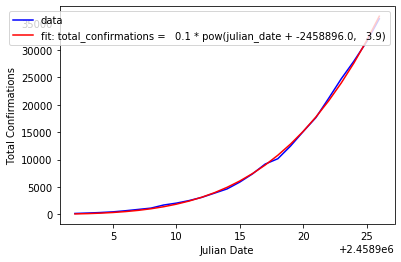

In [141]:

popt, get_total_confirmations_italy = fit_curve('italy')
julian_date = pd.Timestamp(datetime.now()).to_julian_date()
print(julian_date)
confirmed_now = int(get_total_confirmations_italy(julian_date))
doubling_days = math.log(popt[2], 2)
print('Italy will have {:,} confirmed cases today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))

The US will have 40,787 confirmed cases on 3/28. It is doubling every 2.4 days.


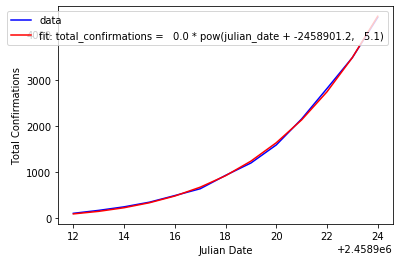

In [144]:

popt, get_total_confirmations_usa = fit_curve('usa')
#julian_date = pd.Timestamp(datetime.now()).to_julian_date()
#julian_date = pd.Timestamp(datetime(year=2020, month=3, day=16)).to_julian_date()
julian_date = pd.Timestamp(datetime(year=2020, month=3, day=28)).to_julian_date()
#print(julian_date)
confirmed_now = int(get_total_confirmations_usa(julian_date))
doubling_days = math.log(popt[2], 2)
print('The US will have {:,} confirmed cases on 3/28. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))

In [137]:

print(popt)

[ 5.14963606e-04 -2.45890117e+06  5.10198976e+00]


2.351060003083751

In [46]:

column_description_dict = s.load_object('column_description_dict')

In [47]:

def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [8]:

for column_name in pandemic_df.columns:
    print(column_name, get_column_description(column_name=column_name))

Disease Disease Name
Transmission Transmission Method
R0 Basic Reproduction Number
Case_fatality_ratio Case Fatality Ratio
Hospitalized_cases_sent_to_ICU Hospitalized Cases Sent To ICU
Asymptomatic_transmission Asymptomatic Transmission
Year_vaccine_available Year Vaccine Available
R0_high Basic Reproduction Number (High Range)
R0_low Basic Reproduction Number (Low Range)
CFR_high Case Fatality Ratio (High Range)
CFR_low Case Fatality Ratio (Low Range)


In [51]:

svg_dir = os.path.join(s.saves_folder, 'svg')
os.makedirs(name=svg_dir, exist_ok=True)

In [59]:

def show_linear_scatterplot(merged_df, columns_list, ev_min_str=None, ev_max_str=None, rv_min_str=None, rv_max_str=None):
    ev_column_name = columns_list[0]
    rv_column_name = columns_list[1]
    explanatory_variable = get_column_description(ev_column_name)
    response_variable = get_column_description(rv_column_name)
    if (ev_min_str is None):
        ev_min_str = 'minimum {}'.format(explanatory_variable)
    if (ev_max_str is None):
        ev_max_str = 'maximum {}'.format(explanatory_variable)
    if (rv_min_str is None):
        rv_min_str = 'minimum {}'.format(response_variable)
    if (rv_max_str is None):
        rv_max_str = 'maximum {}'.format(response_variable)
    
    df = merged_df.copy()
    columns_list = [ev_column_name, rv_column_name]
    df = df[columns_list].dropna()
    ev_max = df[ev_column_name].max()
    ev_min = df[ev_column_name].min()
    rv_min = df[rv_column_name].min()
    rv_max = df[rv_column_name].max()
    ev_max_labeled = False
    ev_min_labeled = False
    rv_min_labeled = False
    rv_max_labeled = False
    
    # First order (linear) scatterplot
    fig1_fig = plt.figure(figsize=(12,8))
    merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                     norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                     plotnonfinite=False, data=df)
    xlabel_text = plt.xlabel('{}'.format(explanatory_variable))
    ylabel_text = plt.ylabel('{}'.format(response_variable))
    
    # Add annotations
    for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
        if (x == ev_min):
            if not ev_min_labeled:
                ev_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
        elif (x == ev_max):
            if not ev_max_labeled:
                ev_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
        elif (y == rv_min):
            if not rv_min_labeled:
                rv_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
        elif (y == rv_max):
            if not rv_max_labeled:
                rv_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
        elif (label == 'SARS'):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, -20), **kwargs)
        elif ('Kong' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 120), **kwargs)
        elif ('Swine' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
        elif ('Seasonal' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-25, 70-1.9397546), **kwargs)
        elif ('Spanish' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
        elif ('19' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-85, 25), **red_kwargs)
        '''else:
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=ev_min_xytext, **kwargs)'''
    
    # Add r-squared
    x = df[ev_column_name].values
    y = df[rv_column_name].values
    plt.text(17.4, 34.4, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
             horizontalalignment='center', verticalalignment='center')
    plt.suptitle(t='Relative Deadliness and Infectiousness of the Wuhan Flu Pandemic', x=0.5, y=0.91)
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    file_path = os.path.join(svg_dir, 'pandemic.svg')
    plt.savefig(file_path)
    with open(file_path, 'r') as f:
        xml_str = f.read()
        d_regex = re.compile('d="([^"\r\n]+)[\r\n]+')
        while d_regex.search(xml_str):
            xml_str = d_regex.sub(r'd="\g<1>', xml_str)
        with open(file_path, 'w') as f:
            print(xml_str.strip(), file=f)
    
    return file_path, left, right, bottom, top

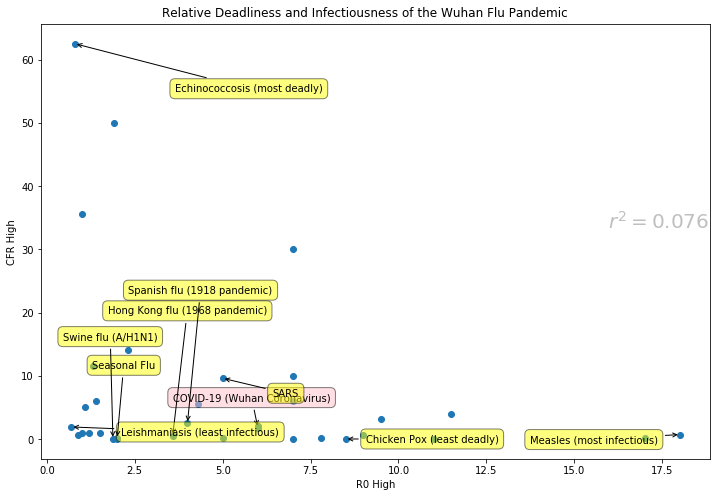

In [60]:

#pandemic_df = s.load_object('pandemic_df')
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
red_kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ev_column_name = 'R0_high'
rv_column_name = 'CFR_high'

ev_min_str = 'least infectious'
ev_max_str = 'most infectious'
rv_min_str = 'least deadly'
rv_max_str = 'most deadly'
ev_min_xytext = (50, -10)
ev_max_xytext = (-150, -10)
rv_min_xytext = (20, -5)
rv_max_xytext = (100, -50)
columns_list = [ev_column_name, rv_column_name]
file_path, left, right, bottom, top = show_linear_scatterplot(pandemic_df, columns_list, ev_min_str=ev_min_str,
                                                              ev_max_str=ev_max_str, rv_min_str=rv_min_str,
                                                              rv_max_str=rv_max_str)
!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(file_path))}"

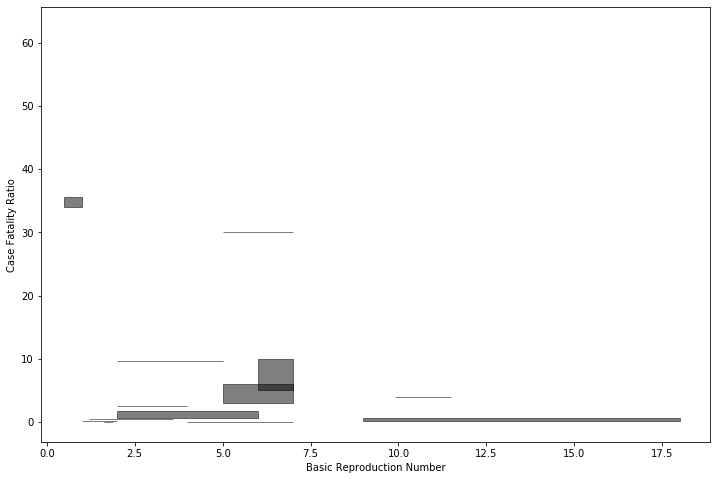

In [63]:

import matplotlib

columns_list = ['R0_high', 'R0_low', 'CFR_high', 'CFR_low']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
match_series = (pandemic_df.index == 'Rubella')
for Disease, row_series in pandemic_df[columns_list].iterrows():
    R0_high = row_series['R0_high']
    R0_low = row_series['R0_low']
    CFR_high = row_series['CFR_high']
    CFR_low = row_series['CFR_low']
    rect = matplotlib.patches.Rectangle((R0_low, CFR_low), R0_high-R0_low, CFR_high-CFR_low, color='black', alpha=0.5)
    ax.add_patch(rect)
    #annotation = plt.annotate('{}'.format(Disease), xy=(int((R0_high+R0_low)/2), int((CFR_high+CFR_low)/2)), xytext=(-85, 20), **red_kwargs)
plt.xlim(left, right)
bottom, top = plt.ylim(bottom, top)
xlabel_text = plt.xlabel('Basic Reproduction Number')
ylabel_text = plt.ylabel('Case Fatality Ratio')

In [178]:

Disease, R0_high, R0_low, CFR_high, CFR_low

('Rubella', 7.0, 5.0, 6.0, 3.0)

In [ ]:

merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                 plotnonfinite=False, data=df)


---
# Create the DataFrame

In [5]:

pandemic_df = s.load_object('pandemic_df')
pandemic_df.loc[12, 'R0_low'] = 2
pandemic_df.loc[12, 'R0_high'] = 6
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\pandemic_df.pickle


In [5]:

pandemic_df.set_index('Disease', drop=True, inplace=True)
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\pandemic_df.pickle


In [11]:

csv_name = 'COVID-19'
csv_path = os.path.abspath(os.path.join(s.data_csv_folder, '{}.csv'.format(csv_name)))
covid19_df = pd.read_csv(csv_path, encoding=s.encoding_type, header=[0, 1])
covid19_df

,updated 9th Mar,deaths per day (global),total news mentions (millions),news mentions per death,Fatality Rate,Infectiousness,annual global fatalities,new cases per year,days of outbreak,fatalty notes,source,URL
,Unnamed: 0_level_1,rounded,data retrieved 3rd Mar 2020,Unnamed: 3_level_1,CFR %,R0,latest data year,latest data year,Unnamed: 8_level_1,Unnamed: 9_level_1,Unnamed: 10_level_1,Unnamed: 11_level_1
0,Tuberculosis,"3,014","2,970,000",986,14.00%,2.3,"1,100,000","9,019,296",NaN,2015,The Lancet,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
1,Hepatitis B,"2,430","182,000",75,0.10%,5.0,"887,000","118,976,405",NaN,2015,WHO,https://www.who.int/news-room/fact-sheets/deta...
2,Pneumonia,"2,216","5,000,000","2,257",5.00%,1.1,"808,694",-,NaN,child deaths,WHO,https://www.who.int/news-room/fact-sheets/deta...
3,HIV,"2,110","40,000,000","18,961",2.10%,6.0,"770,000","1,865,245",NaN,2018,US Gov,https://www.hiv.gov/hiv-basics/overview/data-a...
4,Malaria,"2,002","5,970,000","2,983",0.20%,17.0,"730,550","213,098,073",NaN,"unspecified strain, 555,800-904,000 range",The Lancet,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
5,Shigellosis,"1,644","3,770",2,1.00%,1.5,"600,000","190,849,501",NaN,NaN,CDC,https://wwwnc.cdc.gov/travel/yellowbook/2020/t...
6,Rotavirus,"1,233","60,000",49,0.70%,0.9,"450,000",-,NaN,2008. children <5,CDC,http://www.cdc.gov/rotavirus/surveillance.html...
7,Seasonal Flu,"1,027","202,000",197,0.10%,1.0,"375,000","4,000,000",NaN,"range 250-500,000.",WHO,http://www.who.int/mediacentre/factsheets/fs21...
8,Norovirus,548,"588,000","1,073",0.10%,7.8,"200,000","684,850,131",NaN,NaN,CDC,https://www.cdc.gov/norovirus/downloads/global...


In [10]:

name_regex = re.compile(r'[^0-9A-Za-z]+')
[name_regex.sub('_', '{} {}'.format(cn_tuple[0], cn_tuple[1]).lower()) for cn_tuple in covid19_df.columns]

['updated_9th_mar_unnamed_0_level_1', 'deaths_per_day_global_rounded', 'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death_unnamed_3_level_1', 'fatality_rate_cfr_', 'infectiousness_r0', 'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year', 'days_of_outbreak_unnamed_8_level_1', 'fatalty_notes_unnamed_9_level_1', 'source_unnamed_10_level_1', 'url_unnamed_11_level_1']

In [13]:

covid19_df.columns = ['Disease', 'deaths_per_day_global_rounded', 'total_news_mentions_millions_data_retrieved_3rd_mar_2020',
                      'news_mentions_per_death', 'CFR_low', 'R0_low', 'annual_global_fatalities_latest_data_year',
                      'new_cases_per_year_latest_data_year', 'days_of_outbreak', 'fatalty_notes', 'source', 'url']
covid19_df.set_index('Disease', drop=True, inplace=True)
s.store_objects(covid19_df=covid19_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\covid19_df.pickle


In [27]:

pandemic_df = s.load_object('pandemic_df')
pandemic_df.index = ['Pertussis', 'Diphtheria', 'Measles', 'Smallpox', 'Rubella', 'Mumps', 'SARS', 'MERS', 'Swine flu (A/H1N1)',
                     'Seasonal Flu', 'Hong Kong flu (1968 pandemic)', 'Spanish flu (1918 pandemic)', 'COVID-19 (Wuhan Coronavirus)']
s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\pandemic_df.pickle


In [65]:

s.store_objects(pandemic_df=pandemic_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\pandemic_df.pickle


In [42]:

pandemic_df = s.load_object('pandemic_df')
covid19_df = s.load_object('covid19_df')
pandemic_df = pd.merge(left=pandemic_df, right=covid19_df, how='outer', left_index=True, right_index=True, suffixes=('_old', '_new'))
pandemic_df.columns = ['Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU', 'Asymptomatic_transmission',
                       'Year_vaccine_available', 'R0_high', 'R0_low', 'CFR_high', 'CFR_low', 'deaths_per_day_global_rounded',
                       'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death', 'CFR_new',
                       'R0_new', 'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year',
                       'days_of_outbreak', 'fatalty_notes', 'source', 'url']
columns_list = sorted([cn for cn in pandemic_df.columns if ('_low' in cn) or ('_high' in cn) or ('_new' in cn)])
num_regex = re.compile(r'[^0-9.]+')
for disease_name, row_series in pandemic_df[columns_list].iterrows():
    CFR_high = row_series['CFR_high']
    CFR_low = row_series['CFR_low']
    CFR_new = row_series['CFR_new']
    if str(CFR_new) != 'nan':
        CFR_new = float(num_regex.sub('', str(CFR_new)))
    if str(CFR_high) == 'nan':
        pandemic_df.loc[disease_name, 'CFR_high'] = CFR_new
    if str(CFR_low) == 'nan':
        pandemic_df.loc[disease_name, 'CFR_low'] = CFR_new
    if str(CFR_new) != 'nan':
        if CFR_new < CFR_low:
            pandemic_df.loc[disease_name, 'CFR_low'] = CFR_new
        elif CFR_new > CFR_high:
            pandemic_df.loc[disease_name, 'CFR_high'] = CFR_new
    R0_high = row_series['R0_high']
    R0_low = row_series['R0_low']
    R0_new = row_series['R0_new']
    if str(R0_new) != 'nan':
        R0_new = float(num_regex.sub('', str(R0_new)))
    if str(R0_high) == 'nan':
        pandemic_df.loc[disease_name, 'R0_high'] = R0_new
    if str(R0_low) == 'nan':
        pandemic_df.loc[disease_name, 'R0_low'] = R0_new
    if str(R0_new) != 'nan':
        if R0_new < R0_low:
            pandemic_df.loc[disease_name, 'R0_low'] = R0_new
        elif R0_new > R0_high:
            pandemic_df.loc[disease_name, 'R0_high'] = R0_new
columns_list = ['Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU', 'Asymptomatic_transmission',
                'Year_vaccine_available', 'R0_high', 'R0_low', 'CFR_high', 'CFR_low', 'deaths_per_day_global_rounded',
                'total_news_mentions_millions_data_retrieved_3rd_mar_2020', 'news_mentions_per_death',
                'annual_global_fatalities_latest_data_year', 'new_cases_per_year_latest_data_year',
                'days_of_outbreak', 'fatalty_notes', 'source', 'url']
pandemic_df = pandemic_df[columns_list]
pandemic_df.sample(5).T.sample(6).T

,source,url,CFR_high,Asymptomatic_transmission,deaths_per_day_global_rounded,R0_low
Rubella,NaN,NaN,6,NaN,NaN,5
Typhoid,CDC,http://www.cdc.gov/nczved/divisions/dfbmd/dise...,1,NaN,396,1.2
Leishmaniasis,BMC Public Health,https://bmcpublichealth.biomedcentral.com/arti...,1.9,NaN,55,0.7
Ebola,NaN,https://www.manchestereveningnews.co.uk/news/w...,50,NaN,5.3,1.9
Measles,Oxford Vaccine Group,http://vk.ovg.ox.ac.uk/vk/measles,0.7,NaN,247,9


In [31]:

covid19_df = s.load_object('covid19_df')
covid19_df.index = ['Tuberculosis', 'Hepatitis B', 'Pneumonia', 'HIV ', 'Malaria ', 'Shigellosis', 'Rotavirus', 'Seasonal Flu',
                    'Norovirus', 'Whooping Cough', 'Typhoid', 'Cholera', 'Meningitis', 'Measles', 'Rabies ', 'Yellow Fever',
                    'Leishmaniasis', 'Echinococcosis', 'COVID-19 (Wuhan Coronavirus)', 'Dengue Fever', 'Hepatitis A',
                    'Chicken Pox', 'Sleeping Sickness', 'Ebola', 'SARS', 'MERS']
s.store_objects(covid19_df=covid19_df)

Pickling to C:\Users\dev\Documents\repositories\notebooks\StatsByCountry\saves\pickle\covid19_df.pickle


In [30]:

pandemic_df = s.load_object('pandemic_df')
covid19_df = s.load_object('covid19_df')
check_for_typos(left_list=covid19_df.index.tolist(), right_list=pandemic_df.index.tolist(), verbose=False).sort_values('left_item')

,left_item,right_item,max_similarity
18,COVID-19 (Wuhan Coronavirus),COVID-19 (Wuhan Coronavirus),1.000000
21,Chicken Pox,Seasonal Flu,0.260870
11,Cholera,Diphtheria,0.470588
19,Dengue Fever,Seasonal Flu,0.333333
23,Ebola,Rubella,0.500000
17,Echinococcosis,Pertussis,0.260870
3,HIV,Seasonal Flu,0.125000
20,Hepatitis A,Pertussis,0.400000
1,Hepatitis B,Pertussis,0.400000
16,Leishmaniasis,Pertussis,0.454545


In [2]:

def get_page_soup(page_url):
    with urllib.request.urlopen(page_url) as response:
        page_html = response.read()
    page_soup = bs(page_html, 'html.parser')
    
    return page_soup

In [21]:

tables_url = 'https://www.zorinaq.com/pub/ncov-comparison.html'
ncov_path = os.path.join(s.data_folder, 'html', 'ncov-comparison.html')
#page_soup = get_page_soup(tables_url)
tables_list = get_page_tables(tables_url)

[(0, (13, 7))]


In [54]:

import numpy as np

pandemic_df = tables_list[0].copy()
pandemic_df.columns = ['Disease', 'Transmission', 'R0', 'Case_fatality_ratio', 'Hospitalized_cases_sent_to_ICU',
                       'Asymptomatic_transmission', 'Year_vaccine_available']

def f(x):
    result = re.sub(r' *\(', ' (', str(x))
    
    return result

pandemic_df.Disease = pandemic_df.Disease.map(f)

def f(x):
    result = re.sub(r'⁹', '', str(x))
    
    return result

pandemic_df.Transmission = pandemic_df.Transmission.map(f)
pandemic_df['R0_high'] = np.nan

def f(x):
    result = str(x).split('-')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['R0_high'] = pandemic_df.R0.map(f)
pandemic_df['R0_low'] = np.nan

def f(x):
    result_list = str(x).split('-')
    if len(result_list) < 3:
        result = result_list[0]
    else:
        result = result_list[1].split(' ')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['R0_low'] = pandemic_df.R0.map(f)
pandemic_df['CFR_high'] = np.nan

def f(x):
    result = str(x).split('-')[-1]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['CFR_high'] = pandemic_df.Case_fatality_ratio.map(f)
pandemic_df['CFR_low'] = np.nan

def f(x):
    result_list = str(x).split('-')
    result = result_list[0]
    result = re.sub(r'[^0-9.]+', '', result)
    
    return float(result)

pandemic_df['CFR_low'] = pandemic_df.Case_fatality_ratio.map(f)
#print(pandemic_df.R0.unique().tolist())
#print(pandemic_df.R0.map(f).unique().tolist())
s.store_objects(pandemic_df=pandemic_df)
pandemic_df.sample(5).T

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\pandemic_df.pickle


,9,0,7,4,12
Disease,Seasonal flu,Pertussis,MERS,Rubella,Novel coronavirus (2019-nCoV)
Transmission,Airborne,Airborne droplet,Airborne droplet,Airborne droplet,Airborne droplet
R0,1-2,9.9-11.5,<1¹,5-7,1.4-2.5² 2.47-2.86⁶
Case_fatality_ratio,< 0.1%,4%,34%¹,3-6% (developing world),1.8%⁴
Hospitalized_cases_sent_to_ICU,5-10%⁵,NaN,NaN,NaN,23%³
Asymptomatic_transmission,Yes,NaN,No,NaN,Suspected¹⁰
Year_vaccine_available,seasonal,1930s,NaN,1970,NaN
R0_high,2,11.5,1,7,2.86
R0_low,1,9.9,1,5,2.47
CFR_high,0.1,4,34,6,1.8
